# define imports and get data

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from titeseq_functions import *
from multiprocessing import Pool
from functools import partial

/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
data_location = '/scratch/gthurber_root/gthurber0/marcase/titeseq/'
#upload Bloom 2022 data
vc = pd.read_csv(data_location+'variant_counts.csv')
delta_vc = pd.read_csv(data_location+'delta_variant_counts.csv')
B1351 = pd.read_csv(data_location+'codon_variant_table_B1351.csv') #beta variant K417N+E484K+N501Y 
#where is delta - L452R+T478K? - its stored in a separate repo. process below
E484K = pd.read_csv(data_location+'codon_variant_table_E484K.csv') #eta variant
N501Y = pd.read_csv(data_location+'codon_variant_table_N501Y.csv') #alpha variant 
Wuhan_Hu_1 = pd.read_csv(data_location+'codon_variant_table_Wuhan_Hu_1.csv') #ancestral/ WT
all_variants = pd.concat([B1351,E484K,N501Y,Wuhan_Hu_1])

B1351_seq      =  'NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGNIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVKGFNCYFPLQSYGFQPTYGVGYQPYRVVVLSFELLHAPATVCGPKKST'
E484K_seq      =  'NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVKGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKST'
N5O1Y_seq      =  'NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTYGVGYQPYRVVVLSFELLHAPATVCGPKKST'
Wuhan_Hu_1_seq =  'NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKST'
WT_seq         =  'NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKST'
delta_seq      =  'NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYRYRLFRKSNLKPFERDISTEIYQAGSKPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKST'

#drop duplicate barcodes
all_variants = all_variants.drop_duplicates(subset='barcode')
all_variants = all_variants.set_index(['barcode','library'])
all_variants = all_variants.set_index(all_variants.index.get_level_values(0) + '_' + all_variants.index.get_level_values(1))

#get rid of controls from the delta dataset
delta_vc = delta_vc.loc[~delta_vc['sample'].isin(['delta_17-20-none-0-ref', 'delta_17-P03-1250-abneg',
       'delta_18-P08-500-abneg', 'delta_19-268C-500-abneg',
       'delta_20-279C-1250-abneg', 'delta_21-26-none-0-ref',
       'delta_21-267C-200-abneg', 'delta_22-273C-500-abneg',
       'delta_23-274C-500-abneg', 'delta_24-276C-500-abneg',
       'delta_25-277C-500-abneg', 'delta_26-278C-1250-abneg',
       'delta_27-34-none-0-ref', 'delta_27-Delta_1-500-abneg',
       'delta_28-Delta_3-350-abneg', 'delta_29-Delta_4-350-abneg',
       'delta_30-Delta_6-500-abneg', 'delta_31-Delta_7-1250-abneg',
       'delta_32-Delta_8-500-abneg', 'delta_33-Delta_10-1250-abneg',
       'delta_34-Delta_11-500-abneg', 'delta_35-40-none-0-ref',
       'delta_35-P02-500-abneg', 'delta_36-P04-1250-abneg',
       'delta_37-P05-500-abneg', 'delta_38-P09-200-abneg',
       'delta_39-P12-200-abneg', 'delta_40-P14-1250-abneg'])]

In [3]:
all_variants

,target,variant_call_support,codon_substitutions,aa_substitutions,n_codon_substitutions,n_aa_substitutions
AAAAAAAAAATTAAGG_pool1,B1351,3,AGA73CAT GGA172TCT GCA192ACA,R73H G172S A192T,3.0,3.0
AAAAAAAAAGTATTAA_pool1,B1351,1,GTG103AAA,V103K,1.0,1.0
AAAAAAAAATACAATA_pool1,B1351,4,CCT169GGT,P169G,1.0,1.0
AAAAAAAAATGTTAAT_pool1,B1351,2,GAT75CAA,D75Q,1.0,1.0
AAAAAAAAATTACTAA_pool1,B1351,2,NaN,NaN,0.0,0.0
...,...,...,...,...,...,...
TTTTTTAGTACTAGTT_pool2,Wuhan_Hu_1,2,NaN,NaN,0.0,0.0
TTTTTTATGCAAATTA_pool2,Wuhan_Hu_1,3,GAC34AAT,D34N,1.0,1.0
TTTTTTCAACCCGCGT_pool2,Wuhan_Hu_1,1,AGA73AAT,R73N,1.0,1.0
TTTTTTGATTAAGTTA_pool2,Wuhan_Hu_1,1,TGC61GTT,C61V,1.0,1.0


In [4]:
delta_vc

,target,library,sample,barcode,count,variant_call_support,codon_substitutions,aa_substitutions,n_codon_substitutions,n_aa_substitutions
0,Delta,lib1,TiteSeq_01_bin1,TTAAATCTACTAAAAG,2877,80,CAG176CCA,Q176P,1,1
1,Delta,lib1,TiteSeq_01_bin1,AAAAGCTCCCACCCGA,1883,31,GGT9GAT CAG176CCA,G9D Q176P,2,2
2,Delta,lib1,TiteSeq_01_bin1,AATGACATGGAGCTTA,1727,92,TTC70GAT AAC171AGA,F70D N171R,2,2
3,Delta,lib1,TiteSeq_01_bin1,TCACAATATCGCGTGT,1708,59,GGC86TTT CTG95CTT GCA192TTG,G86F A192L,3,2
4,Delta,lib1,TiteSeq_01_bin1,ATCCAAACAAATTGCA,1630,65,GGA172TCT,G172S,1,1
...,...,...,...,...,...,...,...,...,...,...
10903551,Delta,lib2,SortSeq_bin4,TTTTGTCAATCAACAC,0,1,AAA132ACT,K132T,1,1
10903552,Delta,lib2,SortSeq_bin4,TTTTTGATATGACAGG,0,1,TTC8GTT TTT62CAT,F8V F62H,2,2
10903553,Delta,lib2,SortSeq_bin4,TTTTTTAATAATTGCT,0,2,GCA89GGT,A89G,1,1
10903554,Delta,lib2,SortSeq_bin4,TTTTTTCCACAGACAT,0,2,ATT28CAT,I28H,1,1


## preprocess data - use a pivot table to convert barcodes, pools, and replicates into individual reads

In [5]:
#preprocess data
values='count'
index=['barcode','library','replicate']
columns=['sample']
data = preprocess(vc,values,index,columns)
data #titeseq_bin_01: 1e-6 [M], titeseq_bin_08: 1e-13 [M], titeseq_bin_09: 0 [M]

sample                              SortSeq_bin1  SortSeq_bin2  SortSeq_bin3  \
barcode          library replicate                                             
AAAAAAAAAAAAAGAA pool1   A                   0.0           0.0           2.0   
                         B                   NaN           NaN           NaN   
AAAAAAAAAAAGGAGA pool1   A                   0.0           0.0           0.0   
                         B                   NaN           NaN           NaN   
AAAAAAAAAAATTTAA pool1   A                   0.0           4.0          13.0   
...                                          ...           ...           ...   
TTTTTTTGATATTGGA pool2   A                   0.0          14.0          33.0   
TTTTTTTGGGCATGTA pool2   A                  22.0          28.0           0.0   
TTTTTTTGTGATAGGA pool2   A                   0.0           2.0          11.0   
TTTTTTTTCTTTGCTG pool1   A                   3.0          58.0          20.0   
                         B                   NaN           NaN           NaN   

sample                              SortSeq_bin4  TiteSeq_01_bin1  \
barcode          library replicate                                  
AAAAAAAAAAAAAGAA pool1   A                   1.0              0.0   
                         B                   NaN              0.0   
AAAAAAAAAAAGGAGA pool1   A                   0.0              0.0   
                         B                   NaN             12.0   
AAAAAAAAAAATTTAA pool1   A                  64.0              0.0   
...                                          ...              ...   
TTTTTTTGATATTGGA pool2   A                  12.0             10.0   
TTTTTTTGGGCATGTA pool2   A                   0.0              0.0   
TTTTTTTGTGATAGGA pool2   A                  18.0              0.0   
TTTTTTTTCTTTGCTG pool1   A                   0.0             13.0   
                         B                   NaN              0.0   

sample                              TiteSeq_01_bin2  TiteSeq_01_bin3  \
barcode          library replicate                                     
AAAAAAAAAAAAAGAA pool1   A                      0.0              0.0   
                         B                      0.0              0.0   
AAAAAAAAAAAGGAGA pool1   A                      0.0              0.0   
                         B                     10.0              5.0   
AAAAAAAAAAATTTAA pool1   A                      0.0              8.0   
...                                             ...              ...   
TTTTTTTGATATTGGA pool2   A                      0.0              0.0   
TTTTTTTGGGCATGTA pool2   A                      0.0              0.0   
TTTTTTTGTGATAGGA pool2   A                      0.0              0.0   
TTTTTTTTCTTTGCTG pool1   A                      5.0             17.0   
                         B                      4.0             13.0   

sample                              TiteSeq_01_bin4  TiteSeq_02_bin1  \
barcode          library replicate                                     
AAAAAAAAAAAAAGAA pool1   A                      0.0              0.0   
                         B                      0.0              0.0   
AAAAAAAAAAAGGAGA pool1   A                      0.0              0.0   
                         B                      4.0             30.0   
AAAAAAAAAAATTTAA pool1   A                     79.0              6.0   
...                                             ...              ...   
TTTTTTTGATATTGGA pool2   A                     15.0             50.0   
TTTTTTTGGGCATGTA pool2   A                      0.0              0.0   
TTTTTTTGTGATAGGA pool2   A                     55.0              0.0   
TTTTTTTTCTTTGCTG pool1   A                      0.0             15.0   
                         B                      0.0              0.0   

sample                              TiteSeq_02_bin2  ...  TiteSeq_07_bin3  \
barcode          library replicate                   ...                    
AAAAAAAAAAAAAGAA pool1   A       

### output data for binary analysis (only take the columns at the average Kd corresponding to top and bottom bins)

In [6]:
#output data as if it was sorted without titeseq- one positive bin and one negative bin @ average Kd (1nM = 1e-9 M)
bins_to_keep = ['TiteSeq_04_bin4','TiteSeq_04_bin1']
binary_data= data[bins_to_keep]
binary_data

df1 = binary_data.reset_index()
chunk_size = 10000
chunks = [x for x in range(0, df1.shape[0], chunk_size)]
df1 = pd.concat([df1.iloc[ chunks[i]:chunks[i + 1] - 1 ].pivot(index=['barcode','library'], columns='replicate', values=['TiteSeq_04_bin4','TiteSeq_04_bin1']
) for i in range(0, len(chunks) - 1)])
df1 = df1.set_index(df1.index.get_level_values(0) + '_' + df1.index.get_level_values(1))
df1

TiteSeq_04_bin4      TiteSeq_04_bin1      
replicate                            A    B               A     B
AAAAAAAAAAAAAGAA_pool1             0.0  1.0             0.0   0.0
AAAAAAAAAAAGGAGA_pool1             0.0  1.0             0.0  28.0
AAAAAAAAAAATTTAA_pool1             0.0  0.0             1.0  10.0
AAAAAAAAAACGCGTA_pool1             0.0  0.0             0.0   0.0
AAAAAAAAAACTAAAA_pool2             5.0  NaN             0.0   NaN
...                                ...  ...             ...   ...
TTTTTAGCAAAAACCG_pool1             0.0  1.0             0.0   0.0
TTTTTAGCATTACCCT_pool1             2.0  0.0            93.0  28.0
TTTTTAGCCTATAATT_pool2             0.0  NaN            22.0   NaN
TTTTTAGGACTAGGAG_pool1             0.0  0.0            62.0  18.0
TTTTTAGGCCCGAACT_pool2             0.0  NaN            34.0   NaN

[337386 rows x 4 columns]

In [7]:
#merge binary data with barcode information
merged_binary = pd.concat([all_variants,df1],join='outer',axis=1)
merged_binary

,target,variant_call_support,codon_substitutions,aa_substitutions,n_codon_substitutions,n_aa_substitutions,"(TiteSeq_04_bin4, A)","(TiteSeq_04_bin4, B)","(TiteSeq_04_bin1, A)","(TiteSeq_04_bin1, B)"
AAAAAAAAAATTAAGG_pool1,B1351,3.0,AGA73CAT GGA172TCT GCA192ACA,R73H G172S A192T,3.0,3.0,0.0,0.0,42.0,54.0
AAAAAAAAAGTATTAA_pool1,B1351,1.0,GTG103AAA,V103K,1.0,1.0,0.0,0.0,0.0,2.0
AAAAAAAAATACAATA_pool1,B1351,4.0,CCT169GGT,P169G,1.0,1.0,0.0,0.0,56.0,48.0
AAAAAAAAATGTTAAT_pool1,B1351,2.0,GAT75CAA,D75Q,1.0,1.0,0.0,0.0,0.0,0.0
AAAAAAAAATTACTAA_pool1,B1351,2.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
TTTTTACAATATACAC_pool2,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,205.0,NaN
TTTTTACACAGTAAGT_pool2,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN
TTTTTACCTGTTTGTT_pool2,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,0.0,NaN
TTTTTAGAAAGGTACA_pool2,NaN,NaN,NaN,NaN,NaN,NaN,70.0,NaN,0.0,NaN


## define filter parameters and filter data

In [8]:
#calculate frequencies
data = getFrequencies(data)

#filter data
bin_read_fraction=0.5 #quality control parameter
bin_read_threshold=1 #quality control parameter
bimodal_removal=True #quality control parameter
bimodal_removal_threshold=0.8 #quality control parameter
minimum_fraction_removal=0 #quality control parameter
num_bins=4 #from experiment set-up
num_concs=10 #from experiment set-up
filtered_bin_frequencies,masked_concs = filterClones(data,bin_read_fraction,bin_read_threshold,bimodal_removal,bimodal_removal_threshold,
                 minimum_fraction_removal,num_bins,num_concs)

## get bin scores for dataset and plot a sample fit

<AxesSubplot:>

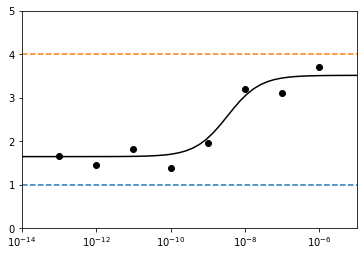

In [9]:
#get data ready for fit
fit_data = getBinScores(data,masked_concs,num_concs=num_concs,num_bins=num_bins)

#plot sample fits
concs = [0,1e-13,1e-12,1e-11,1e-10,1e-9,1e-8,1e-7,1e-6,'sortseq'][::-1]
barcode = ('AAAAAAAAAAATTTAA', 'pool1', 'A')
plotCurveFit(fit_data,barcode,concs)

## fit data for entire dataset and plot Kd distribution

In [10]:
# fit entire dataset
ncpus = 16
fit_params = multiprocessFit(fit_data,ncpus,concs,n_bins=4,verbose=False)

/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/

<AxesSubplot:xlabel='Affinity [M]', ylabel='Count'>

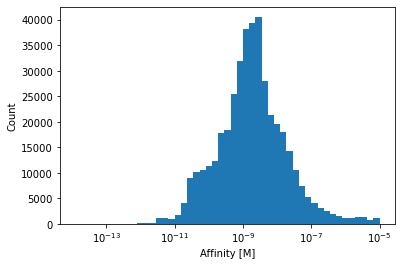

In [11]:
plotDatasetHistogram(fit_params,concs)

## prepare fit data for merging of barcodes with sequences for downstream analysis

In [12]:
#match barcodes with mutations
good_fit_params = fit_params.loc[fit_params['Kd'] > 0.1*np.ma.masked_equal(concs[1:], 0.0, copy=False).min()][['Kd']]

In [13]:
df1 = good_fit_params.reset_index()
chunk_size = 10000
chunks = [x for x in range(0, df1.shape[0], chunk_size)]
good_fit_params = pd.concat([df1.iloc[ chunks[i]:chunks[i + 1] - 1 ].pivot(index=['barcode','library'], columns='replicate', values='Kd') for i in range(0, len(chunks) - 1)])
good_fit_params = good_fit_params.set_index(good_fit_params.index.get_level_values(0) + '_' + good_fit_params.index.get_level_values(1))
good_fit_params

replicate,A,B
AAAAAAAAAAAGGAGA_pool1,NaN,0.0
AAAAAAAAAAATTTAA_pool1,0.0,0.0
AAAAAAAAAACGCGTA_pool1,0.0,0.0
AAAAAAAAAACTAAAA_pool2,0.0,NaN
AAAAAAAAAACTCCAA_pool1,0.0,0.0
...,...,...
TTTTGATCCGTGTAAT_pool2,0.0,NaN
TTTTGATCGAGGCTCT_pool1,0.0,0.0
TTTTGATGAACAATTA_pool2,0.0,NaN
TTTTGATGCACCCCAA_pool2,0.0,NaN


In [14]:
merged = pd.concat([all_variants,good_fit_params],join='outer',axis=1)
merged

,target,variant_call_support,codon_substitutions,aa_substitutions,n_codon_substitutions,n_aa_substitutions,A,B
AAAAAAAAAATTAAGG_pool1,B1351,3.0,AGA73CAT GGA172TCT GCA192ACA,R73H G172S A192T,3.0,3.0,NaN,NaN
AAAAAAAAAGTATTAA_pool1,B1351,1.0,GTG103AAA,V103K,1.0,1.0,NaN,NaN
AAAAAAAAATACAATA_pool1,B1351,4.0,CCT169GGT,P169G,1.0,1.0,0.0,0.0
AAAAAAAAATGTTAAT_pool1,B1351,2.0,GAT75CAA,D75Q,1.0,1.0,0.0,0.0
AAAAAAAAATTACTAA_pool1,B1351,2.0,NaN,NaN,0.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...
TTTTGACGAGAAAACC_pool2,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
TTTTGACGTAACGTCC_pool2,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
TTTTGACTATTAATAT_pool2,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
TTTTGATACGGGCAGA_pool2,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN


In [15]:
merged.loc[(~(pd.isnull(merged['target']))) & (~(pd.isnull(merged['A'])) | (~pd.isnull(merged['B'])))]

,target,variant_call_support,codon_substitutions,aa_substitutions,n_codon_substitutions,n_aa_substitutions,A,B
AAAAAAAAATACAATA_pool1,B1351,4.0,CCT169GGT,P169G,1.0,1.0,0.0,0.0
AAAAAAAAATGTTAAT_pool1,B1351,2.0,GAT75CAA,D75Q,1.0,1.0,0.0,0.0
AAAAAAAACAGGATTG_pool1,B1351,4.0,ATC80ATG,I80M,1.0,1.0,0.0,0.0
AAAAAAAAGTAACGAT_pool1,B1351,6.0,TCT36TAT,S36Y,1.0,1.0,0.0,0.0
AAAAAAAATATGGACA_pool1,B1351,2.0,AAC4TCT,N4S,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...
TTTTGACAGTTATAGA_pool2,Wuhan_Hu_1,6.0,GCC67GGT,A67G,1.0,1.0,0.0,NaN
TTTTGACCCAAACGAA_pool2,Wuhan_Hu_1,1.0,ATA104GTT GAA186GGA,I104V E186G,2.0,2.0,0.0,NaN
TTTTGACCCTACATTA_pool2,Wuhan_Hu_1,4.0,AAT13GAA,N13E,1.0,1.0,0.0,NaN
TTTTGACTAATTTTGT_pool2,Wuhan_Hu_1,1.0,AAT58GTT,N58V,1.0,1.0,0.0,NaN


## look at correlations in dataset

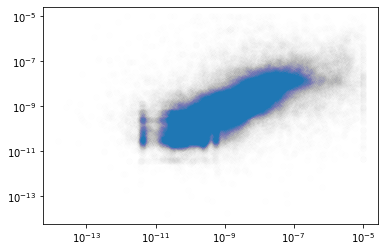

In [16]:
plt.scatter(merged['A'],merged['B'],alpha=0.005)
plt.yscale('log')
plt.xscale('log')

### output data for downstream analysis

In [17]:
merged.to_csv('fit_params.csv')

In [18]:
merged = pd.read_csv('fit_params.csv')

/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (1,3,4) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [19]:
delta_vc

,target,library,sample,barcode,count,variant_call_support,codon_substitutions,aa_substitutions,n_codon_substitutions,n_aa_substitutions
0,Delta,lib1,TiteSeq_01_bin1,TTAAATCTACTAAAAG,2877,80,CAG176CCA,Q176P,1,1
1,Delta,lib1,TiteSeq_01_bin1,AAAAGCTCCCACCCGA,1883,31,GGT9GAT CAG176CCA,G9D Q176P,2,2
2,Delta,lib1,TiteSeq_01_bin1,AATGACATGGAGCTTA,1727,92,TTC70GAT AAC171AGA,F70D N171R,2,2
3,Delta,lib1,TiteSeq_01_bin1,TCACAATATCGCGTGT,1708,59,GGC86TTT CTG95CTT GCA192TTG,G86F A192L,3,2
4,Delta,lib1,TiteSeq_01_bin1,ATCCAAACAAATTGCA,1630,65,GGA172TCT,G172S,1,1
...,...,...,...,...,...,...,...,...,...,...
10903551,Delta,lib2,SortSeq_bin4,TTTTGTCAATCAACAC,0,1,AAA132ACT,K132T,1,1
10903552,Delta,lib2,SortSeq_bin4,TTTTTGATATGACAGG,0,1,TTC8GTT TTT62CAT,F8V F62H,2,2
10903553,Delta,lib2,SortSeq_bin4,TTTTTTAATAATTGCT,0,2,GCA89GGT,A89G,1,1
10903554,Delta,lib2,SortSeq_bin4,TTTTTTCCACAGACAT,0,2,ATT28CAT,I28H,1,1


# delta variants are stored separately. analyze them as above and merge into the dataset

In [20]:
#preprocess data for delta
values='count'
index=['barcode','library']
columns=['sample']
delta_data = preprocess(delta_vc,values,index,columns)

In [21]:
delta_data

,sample,SortSeq_bin1,SortSeq_bin2,SortSeq_bin3,SortSeq_bin4,TiteSeq_01_bin1,TiteSeq_01_bin2,TiteSeq_01_bin3,TiteSeq_01_bin4,TiteSeq_02_bin1,TiteSeq_02_bin2,...,TiteSeq_07_bin3,TiteSeq_07_bin4,TiteSeq_08_bin1,TiteSeq_08_bin2,TiteSeq_08_bin3,TiteSeq_08_bin4,TiteSeq_09_bin1,TiteSeq_09_bin2,TiteSeq_09_bin3,TiteSeq_09_bin4
barcode,library,,,,,,,,,,,,,,,,,,,,,
AAAAAAAAAAAAACCT,lib2,0,10,18,17,0,0,5,4,0,0,...,0,0,36,0,0,0,1,1,0,0
AAAAAAAAAAAAGGAT,lib1,0,4,3,3,0,0,0,11,0,0,...,0,0,6,0,0,0,1,0,0,0
AAAAAAAAAAATGCAA,lib2,49,83,97,204,0,0,36,416,0,0,...,0,0,239,16,0,0,238,0,0,0
AAAAAAAAAAATTCGC,lib1,23,64,186,122,0,0,32,368,0,0,...,0,0,162,3,0,0,276,3,0,0
AAAAAAAAAACACCTA,lib2,5,27,33,84,0,0,0,139,0,0,...,0,0,22,7,0,0,54,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTTTTTGATACCAAG,lib1,4,2,18,0,0,0,0,3,0,0,...,0,0,35,0,3,0,0,0,0,0
TTTTTTTTCAAGATGA,lib2,174,72,0,0,75,6,0,1,48,34,...,0,0,59,5,0,0,63,24,0,0
TTTTTTTTCCAATCAT,lib1,31,26,22,35,0,0,1,47,0,0,...,0,0,100,0,0,0,106,0,0,0


### output binary data for delta variants

In [22]:
#output delta data as if it was sorted without titeseq- one positive bin and one negative bin @ average Kd (1nM = 1e-9 M)
bins_to_keep = ['TiteSeq_04_bin4','TiteSeq_04_bin1']
binary_data= delta_data[bins_to_keep]
binary_data

,sample,TiteSeq_04_bin4,TiteSeq_04_bin1
barcode,library,,
AAAAAAAAAAAAACCT,lib2,0,0
AAAAAAAAAAAAGGAT,lib1,0,1
AAAAAAAAAAATGCAA,lib2,0,125
AAAAAAAAAAATTCGC,lib1,0,39
AAAAAAAAAACACCTA,lib2,0,0
...,...,...,...
TTTTTTTGATACCAAG,lib1,0,0
TTTTTTTTCAAGATGA,lib2,0,170
TTTTTTTTCCAATCAT,lib1,0,0


In [23]:
#prepare delta binary data for merging with barcode info
df1 = binary_data.reset_index()
df1['replicate'] = 'A'
chunk_size = 10000
chunks = [x for x in range(0, df1.shape[0], chunk_size)]
df1 = pd.concat([df1.iloc[ chunks[i]:chunks[i + 1] - 1 ].pivot(index=['barcode','library'], columns='replicate', values=['TiteSeq_04_bin4','TiteSeq_04_bin1']
) for i in range(0, len(chunks) - 1)])
df1 = df1.set_index(df1.index.get_level_values(0) + '_' + df1.index.get_level_values(1))
df1

,TiteSeq_04_bin4,TiteSeq_04_bin1
replicate,A,A
AAAAAAAAAAAAACCT_lib2,0,0
AAAAAAAAAAAAGGAT_lib1,0,1
AAAAAAAAAAATGCAA_lib2,0,125
AAAAAAAAAAATTCGC_lib1,0,39
AAAAAAAAAACACCTA_lib2,0,0
...,...,...
TTCTGCCTCGGTATAC_lib1,0,80
TTCTGCCTGTCATTAA_lib1,0,293
TTCTGCGAAGATACCA_lib2,0,0


In [24]:
#calculate frequencies for delta
delta_data = getFrequencies(delta_data)

#filter data for delta
bin_read_fraction=0.5 #quality control parameter
bin_read_threshold=1 #quality control parameter
bimodal_removal=True #quality control parameter
bimodal_removal_threshold=0.8 #quality control parameter
minimum_fraction_removal=0 #quality control parameter
num_bins=4 #from experiment set-up
num_concs=10 #from experiment set-up
delta_filtered_bin_frequencies,delta_masked_concs = filterClones(delta_data,bin_read_fraction,bin_read_threshold,bimodal_removal,bimodal_removal_threshold,
                 minimum_fraction_removal,num_bins,num_concs)

In [25]:
delta_filtered_bin_frequencies

,sample,SortSeq_bin1,SortSeq_bin2,SortSeq_bin3,SortSeq_bin4,TiteSeq_01_bin1,TiteSeq_01_bin2,TiteSeq_01_bin3,TiteSeq_01_bin4,TiteSeq_02_bin1,TiteSeq_02_bin2,...,TiteSeq_07_bin3,TiteSeq_07_bin4,TiteSeq_08_bin1,TiteSeq_08_bin2,TiteSeq_08_bin3,TiteSeq_08_bin4,TiteSeq_09_bin1,TiteSeq_09_bin2,TiteSeq_09_bin3,TiteSeq_09_bin4
barcode,library,,,,,,,,,,,,,,,,,,,,,
AAAAAAAAAAATTCGC,lib1,1.635078e-06,2.891586e-06,9.547434e-06,5.315912e-06,0.000000e+00,0.000000,6.068631e-06,1.133382e-05,0.000000e+00,0.000000,...,0.0,0.000000,0.000004,2.374364e-06,0.0,0.0,7.271320e-06,0.000004,0.0,0.0
AAAAAAAAAACCTAAC,lib1,4.905235e-06,3.975930e-06,1.442381e-05,1.690634e-05,0.000000e+00,0.000000,4.741118e-06,1.561480e-05,0.000000e+00,0.000000,...,0.0,0.000000,0.000014,9.497458e-06,0.0,0.0,1.643951e-05,0.000004,0.0,0.0
AAAAAAAAAAGACGAG,lib2,1.123228e-05,1.052718e-05,6.672938e-07,5.228766e-07,2.439864e-05,0.000006,1.896447e-07,2.771858e-07,1.437954e-05,0.000004,...,0.0,0.000000,0.000002,6.331639e-06,0.0,0.0,1.238232e-06,0.000010,0.0,0.0
AAAAAAAAACGCCACT,lib2,2.466836e-05,3.736471e-05,7.494222e-06,1.176472e-06,7.606635e-05,0.000021,4.361828e-06,1.231937e-07,8.553986e-05,0.000034,...,0.0,0.000000,0.000017,2.374364e-05,0.0,0.0,5.321763e-06,0.000032,0.0,0.0
AAAAAAAAATCTTGAA,lib1,1.450243e-05,2.209352e-05,3.315937e-05,2.919395e-06,8.922248e-05,0.000059,5.689341e-07,1.509123e-06,8.683033e-05,0.000060,...,0.0,0.000109,0.000027,7.914548e-07,0.0,0.0,1.578087e-05,0.000005,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTTTTAGATAATGCC,lib2,3.056886e-06,5.331361e-06,1.303789e-05,2.135080e-05,0.000000e+00,0.000000,4.172184e-06,1.139542e-05,0.000000e+00,0.000000,...,0.0,0.000000,0.000009,3.244965e-05,0.0,0.0,7.113247e-06,0.000006,0.0,0.0
TTTTTTCAAAAACAGA,lib1,2.630343e-06,2.259051e-06,7.699543e-06,7.450992e-06,7.176070e-07,0.000007,3.546356e-05,3.788206e-06,5.530594e-07,0.000016,...,0.0,0.000000,0.000012,1.108037e-05,0.0,0.0,1.124947e-05,0.000001,0.0,0.0
TTTTTTCGTGCATCGG,lib2,7.109036e-06,1.012055e-05,1.391051e-05,1.337693e-05,0.000000e+00,0.000000,7.585789e-07,2.312962e-05,0.000000e+00,0.000000,...,0.0,0.000000,0.000016,6.331639e-06,0.0,0.0,1.119678e-05,0.000022,0.0,0.0


In [26]:
#get delta data ready for fit
delta_fit_data = getBinScores(delta_data,delta_masked_concs,num_concs=num_concs,num_bins=num_bins)

#concentrations are same for delta as for others
concs = [0,1e-13,1e-12,1e-11,1e-10,1e-9,1e-8,1e-7,1e-6,'sortseq'][::-1]

# fit entire delta dataset
ncpus = 16
delta_fit_params = multiprocessFit(delta_fit_data,ncpus,concs,n_bins=4,verbose=False)

/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/

<AxesSubplot:xlabel='Affinity [M]', ylabel='Count'>

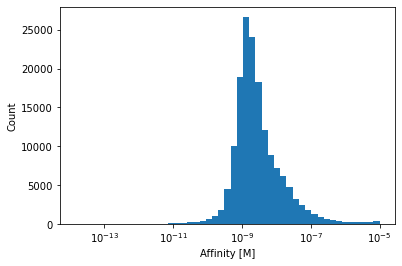

In [27]:
#plot delta distributions of Kds
plotDatasetHistogram(delta_fit_params,concs)

In [28]:
#match barcodes with mutations (delta)
delta_good_fit_params = delta_fit_params.loc[delta_fit_params['Kd'] > 0.1*np.ma.masked_equal(concs[1:], 0.0, copy=False).min()][['Kd']]
delta_good_fit_params

,,Kd
barcode,library,
AAAAAAAAAAAAACCT,lib2,0.0
AAAAAAAAAAATGCAA,lib2,0.0
AAAAAAAAAAATTCGC,lib1,0.0
AAAAAAAAAACACCTA,lib2,0.0
AAAAAAAAAACCTAAC,lib1,0.0
...,...,...
TTTTTTTATTAACAGA,lib1,0.0
TTTTTTTCTGGATCCT,lib2,0.0
TTTTTTTCTGTGAAGT,lib2,0.0


In [29]:
#rearrange delta dataframe for merging
delta_good_fit_params = delta_good_fit_params.reset_index()
delta_good_fit_params = delta_good_fit_params.set_index(delta_good_fit_params['barcode'] + '_' + delta_good_fit_params['library'])
delta_good_fit_params = delta_good_fit_params.drop(columns=['barcode','library'])
delta_good_fit_params

,Kd
AAAAAAAAAAAAACCT_lib2,0.0
AAAAAAAAAAATGCAA_lib2,0.0
AAAAAAAAAAATTCGC_lib1,0.0
AAAAAAAAAACACCTA_lib2,0.0
AAAAAAAAAACCTAAC_lib1,0.0
...,...
TTTTTTTATTAACAGA_lib1,0.0
TTTTTTTCTGGATCCT_lib2,0.0
TTTTTTTCTGTGAAGT_lib2,0.0
TTTTTTTTCCAATCAT_lib1,0.0


In [30]:
#rearrange delta barcode dataframe for merging
delta_to_merge = delta_vc[['target','library','barcode','variant_call_support','codon_substitutions','aa_substitutions','n_codon_substitutions','n_aa_substitutions']]
delta_to_merge = delta_to_merge.set_index(delta_to_merge['barcode'] + '_' + delta_to_merge['library'])
delta_to_merge = delta_to_merge.drop_duplicates()
delta_to_merge = delta_to_merge.drop(columns=['barcode','library'])
delta_to_merge

,target,variant_call_support,codon_substitutions,aa_substitutions,n_codon_substitutions,n_aa_substitutions
TTAAATCTACTAAAAG_lib1,Delta,80,CAG176CCA,Q176P,1,1
AAAAGCTCCCACCCGA_lib1,Delta,31,GGT9GAT CAG176CCA,G9D Q176P,2,2
AATGACATGGAGCTTA_lib1,Delta,92,TTC70GAT AAC171AGA,F70D N171R,2,2
TCACAATATCGCGTGT_lib1,Delta,59,GGC86TTT CTG95CTT GCA192TTG,G86F A192L,3,2
ATCCAAACAAATTGCA_lib1,Delta,65,GGA172TCT,G172S,1,1
...,...,...,...,...,...,...
TTTTTTGGAGTTTCGG_lib2,Delta,8,GTA37ATG,V37M,1,1
TTTTTTGGGATCATTT_lib2,Delta,12,TTA162TGT,L162C,1,1
TTTTTTGTATATGCCA_lib2,Delta,12,NaN,NaN,0,0
TTTTTTTACCGCCTTT_lib2,Delta,5,NaN,NaN,0,0


In [31]:
#merge fit Kds with barcodes and barcodes info
delta_merge = pd.concat([delta_good_fit_params,delta_to_merge],join='outer',axis=1)
delta_merge

,Kd,target,variant_call_support,codon_substitutions,aa_substitutions,n_codon_substitutions,n_aa_substitutions
AAAAAAAAAAAAACCT_lib2,0.0,Delta,2,AAC4TAT ATT142TTG,N4Y I142L,2,2
AAAAAAAAAAATGCAA_lib2,0.0,Delta,7,GAA154TTT,E154F,1,1
AAAAAAAAAAATTCGC_lib1,0.0,Delta,8,AAG48TAT,K48Y,1,1
AAAAAAAAAACACCTA_lib2,0.0,Delta,2,NaN,NaN,0,0
AAAAAAAAAACCTAAC_lib1,0.0,Delta,17,GGG146GAT,G146D,1,1
...,...,...,...,...,...,...,...
TTTTTCAAAACACACA_lib2,NaN,Delta,1,GTC173ATG,V173M,1,1
TTTTTCGAAACTTATT_lib2,NaN,Delta,1,NaN,NaN,0,0
TTTTTGATATGACAGG_lib2,NaN,Delta,1,TTC8GTT TTT62CAT,F8V F62H,2,2
TTTTTTAAACGGAATA_lib2,NaN,Delta,1,NaN,NaN,0,0


In [32]:
#merge delta binary data with barcode info
delta_binary_merge = pd.concat([delta_to_merge,df1],join='outer',axis=1)
delta_binary_merge

,target,variant_call_support,codon_substitutions,aa_substitutions,n_codon_substitutions,n_aa_substitutions,"(TiteSeq_04_bin4, A)","(TiteSeq_04_bin1, A)"
TTAAATCTACTAAAAG_lib1,Delta,80,CAG176CCA,Q176P,1,1,0.0,4927.0
AAAAGCTCCCACCCGA_lib1,Delta,31,GGT9GAT CAG176CCA,G9D Q176P,2,2,0.0,2834.0
AATGACATGGAGCTTA_lib1,Delta,92,TTC70GAT AAC171AGA,F70D N171R,2,2,0.0,3116.0
TCACAATATCGCGTGT_lib1,Delta,59,GGC86TTT CTG95CTT GCA192TTG,G86F A192L,3,2,5.0,2320.0
ATCCAAACAAATTGCA_lib1,Delta,65,GGA172TCT,G172S,1,1,0.0,3196.0
...,...,...,...,...,...,...,...,...
TTTTTTGGAGTTTCGG_lib2,Delta,8,GTA37ATG,V37M,1,1,NaN,NaN
TTTTTTGGGATCATTT_lib2,Delta,12,TTA162TGT,L162C,1,1,NaN,NaN
TTTTTTGTATATGCCA_lib2,Delta,12,NaN,NaN,0,0,NaN,NaN
TTTTTTTACCGCCTTT_lib2,Delta,5,NaN,NaN,0,0,NaN,NaN


# merge delta variants with all other variants and export for downstream analysis"

In [33]:
all_binary_data = pd.concat([delta_binary_merge,merged_binary])
all_binary_data.to_csv('merged_binary_bloom2022.csv')

In [34]:
#add delta data to other data
all_data = pd.concat([merged,delta_merge])

In [35]:
all_data

,Unnamed: 0,target,variant_call_support,codon_substitutions,aa_substitutions,n_codon_substitutions,n_aa_substitutions,A,B,Kd
0,AAAAAAAAAATTAAGG_pool1,B1351,3.0,AGA73CAT GGA172TCT GCA192ACA,R73H G172S A192T,3.0,3.0,NaN,NaN,NaN
1,AAAAAAAAAGTATTAA_pool1,B1351,1.0,GTG103AAA,V103K,1.0,1.0,NaN,NaN,NaN
2,AAAAAAAAATACAATA_pool1,B1351,4.0,CCT169GGT,P169G,1.0,1.0,1.072727e-08,1.055348e-08,NaN
3,AAAAAAAAATGTTAAT_pool1,B1351,2.0,GAT75CAA,D75Q,1.0,1.0,2.812531e-09,1.183789e-09,NaN
4,AAAAAAAAATTACTAA_pool1,B1351,2.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
TTTTTCAAAACACACA_lib2,NaN,Delta,1.0,GTC173ATG,V173M,1.0,1.0,NaN,NaN,NaN
TTTTTCGAAACTTATT_lib2,NaN,Delta,1.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN
TTTTTGATATGACAGG_lib2,NaN,Delta,1.0,TTC8GTT TTT62CAT,F8V F62H,2.0,2.0,NaN,NaN,NaN
TTTTTTAAACGGAATA_lib2,NaN,Delta,1.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN


In [36]:
#output data for downstream analysis
all_data.to_csv('fit_params_bloom2022.csv')

# output a file that has raw sequences and fit Kd's

In [38]:
#get sequences for all mutants
new_sequences = []
for target,aa_substitutions in zip(all_data['target'],all_data['aa_substitutions']):
    new_sequences.append(mutate_sequence(target,aa_substitutions))
new_sequences[:5]

[' NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIHGDEVRQIAPGQTGNIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVKGFNCYFPLQSYGFQPTYSVGYQPYRVVVLSFELLHAPTTVCGPKKST',
 ' NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGNIADYNYKLPDDFTGCKIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVKGFNCYFPLQSYGFQPTYGVGYQPYRVVVLSFELLHAPATVCGPKKST',
 ' NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGNIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVKGFNCYFPLQSYGFQGTYGVGYQPYRVVVLSFELLHAPATVCGPKKST',
 ' NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGQEVRQIAPGQTGNIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVKGFNCYFPLQSYGFQPTYGVGYQPYRVVVLSFELLHAPATVCGPKKST',
 '']

In [ ]:
#drop rows where there's no sequence (probably because a barcode wasn't found from the previous data processing step)
all_data['sequence']=new_sequences
all_data= all_data.loc[all_data['sequence'].str.len() > 0]
all_data = all_data.drop(columns=['Unnamed: 0','target','variant_call_support','codon_substitutions','aa_substitutions','n_codon_substitutions','n_aa_substitutions'])
all_data

In [44]:
all_data = all_data.set_index('sequence')

In [45]:
all_data

,A,B,Kd
sequence,,,
NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIHGDEVRQIAPGQTGNIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVKGFNCYFPLQSYGFQPTYSVGYQPYRVVVLSFELLHAPTTVCGPKKST,NaN,NaN,NaN
NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGNIADYNYKLPDDFTGCKIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVKGFNCYFPLQSYGFQPTYGVGYQPYRVVVLSFELLHAPATVCGPKKST,NaN,NaN,NaN
NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGNIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVKGFNCYFPLQSYGFQGTYGVGYQPYRVVVLSFELLHAPATVCGPKKST,1.072727e-08,1.055348e-08,NaN
NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGQEVRQIAPGQTGNIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVKGFNCYFPLQSYGFQPTYGVGYQPYRVVVLSFELLHAPATVCGPKKST,2.812531e-09,1.183789e-09,NaN
NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQMAPGQTGNIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVKGFNCYFPLQSYGFQPTYGVGYQPYRVVVLSFELLHAPATVCGPKKST,8.101692e-09,2.121484e-09,NaN
...,...,...,...
NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYRYRLFRKSNLTPFERDISTEIYQAGSKPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKST,NaN,NaN,NaN
NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYRYRLFRKSNLKPFERDISTEIYQAGSKPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGGKKST,NaN,NaN,NaN
NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYRYRLFRKSNLKPFERDISTEIYQAGSKPCNGVEGFNCYFPLQSYGFQPTNGMGYQPYRVVVLSFELLHAPATVCGPKKST,NaN,NaN,NaN


In [47]:
#group barcodes together for stat calculations more generally
df1 = pd.DataFrame(index=all_data.index.unique(),columns=all_data.columns)
all_data['Kds'] = all_data[['A','B','Kd']].values.tolist()
df1['Kds'] = all_data.groupby('sequence')['Kds'].apply(lambda x: list([item for sublist in x for item in sublist]))
df1 = df1.drop(columns=df1.columns[:-1])
df1

,Kds
sequence,
NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIHGDEVRQIAPGQTGNIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVKGFNCYFPLQSYGFQPTYSVGYQPYRVVVLSFELLHAPTTVCGPKKST,"[nan, nan, nan]"
NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGNIADYNYKLPDDFTGCKIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVKGFNCYFPLQSYGFQPTYGVGYQPYRVVVLSFELLHAPATVCGPKKST,"[nan, nan, nan, nan, nan, nan, nan, 3.29270813..."
NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGNIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVKGFNCYFPLQSYGFQGTYGVGYQPYRVVVLSFELLHAPATVCGPKKST,"[1.072726884839601e-08, 1.0553483846502093e-08..."
NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGQEVRQIAPGQTGNIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVKGFNCYFPLQSYGFQPTYGVGYQPYRVVVLSFELLHAPATVCGPKKST,"[2.8125311010685614e-09, 1.18378918408883e-09,..."
NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQMAPGQTGNIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVKGFNCYFPLQSYGFQPTYGVGYQPYRVVVLSFELLHAPATVCGPKKST,"[8.101692111850255e-09, 2.1214838792587013e-09..."
...,...
NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYAD*FVIRADEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYRYRLFRKSNLKPFERDISTEIYQAGSKPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKST,"[nan, nan, nan]"
NITNPCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNGRYRLFRKSNLKPFERDISTEIYQAGSKPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKST,"[nan, nan, nan]"
NYTNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYRYRLFRKSNLKPFERDISTEITQAGSKPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKST,"[nan, nan, nan]"


In [51]:
#calculate stats
df1['Kds'] = df1['Kds'].apply(lambda x: [i for i in x if not np.isnan(i)])
df1['mean'] = df1['Kds'].apply(lambda x: np.nanmean(x))
df1['count'] = df1['Kds'].apply(lambda x: len(x))
df1['std'] = df1['Kds'].apply(np.std)

/tmp/ipykernel_2578642/3665757402.py:3: RuntimeWarning: Mean of empty slice
  df1['mean'] = df1['Kds'].apply(lambda x: np.nanmean(x))
/home/marcase/.local/lib/python3.9/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [55]:
df1 = df1.dropna(subset=['mean'])
df1

,Kds,mean,count,std
sequence,,,,
NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGNIADYNYKLPDDFTGCKIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVKGFNCYFPLQSYGFQPTYGVGYQPYRVVVLSFELLHAPATVCGPKKST,"[3.2927081345449904e-08, 7.862162152770024e-07...",1.601152e-07,15,3.784540e-07
NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGNIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVKGFNCYFPLQSYGFQGTYGVGYQPYRVVVLSFELLHAPATVCGPKKST,"[1.072726884839601e-08, 1.0553483846502093e-08...",2.670977e-08,33,4.654992e-08
NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGQEVRQIAPGQTGNIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVKGFNCYFPLQSYGFQPTYGVGYQPYRVVVLSFELLHAPATVCGPKKST,"[2.8125311010685614e-09, 1.18378918408883e-09,...",2.638456e-09,25,2.190593e-09
NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQMAPGQTGNIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVKGFNCYFPLQSYGFQPTYGVGYQPYRVVVLSFELLHAPATVCGPKKST,"[8.101692111850255e-09, 2.1214838792587013e-09...",1.361575e-08,41,2.676073e-08
NITNLCPFGEVFNATRFASVYAENRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGNIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVKGFNCYFPLQSYGFQPTYGVGYQPYRVVVLSFELLHAPATVCGPKKST,"[8.285952069807347e-06, 5.510779964128036e-06,...",1.976634e-06,11,3.233718e-06
...,...,...,...,...
NITNLCPFGEVFNATRFASVYAWNRKRNSNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYTDSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYRYRLFRKSNLKPFERDISTEIYQAGSKPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKST,[5.396585178005522e-08],5.396585e-08,1,0.000000e+00
NITNLCPFGEVFNATRFASVYAWNRIRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQPGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYRYRLFRKSNLKPFERDISTEIYQAGSKPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKST,[8.593898456303798e-09],8.593898e-09,1,0.000000e+00
NITLLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYRYRLFRKSQLKPFERDISTEIYQAGSKPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKST,[6.039575630247964e-10],6.039576e-10,1,0.000000e+00


In [56]:
df1.to_csv('continuous_bloom2022.csv')